In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import random
import tensorflow as tf
from tensorflow import keras
import keras.layers as tfl
import seaborn as sn
import dataset

Integrated part for dataset preprocessing and splitting

In [2]:
# interfacce function to get splited dataset
dataset_collection = dataset.getMFCCDataset(train_size = 0.6, valid_size = 0.2, test_size = 0.2)

X_train = dataset_collection['X_train']
Y_train = dataset_collection['Y_train']
X_valid = dataset_collection['X_valid']
Y_valid = dataset_collection['Y_valid']
X_test = dataset_collection['X_test']
Y_test = dataset_collection['Y_test']

X_train_norm = dataset_collection['X_train_norm']
X_valid_norm = dataset_collection['X_valid_norm']
X_test_norm = dataset_collection['X_test_norm']

In [3]:
# convert array to tensor
X_train_norm = tf.convert_to_tensor(X_train_norm)
X_valid_norm = tf.convert_to_tensor(X_valid_norm)
X_test_norm = tf.convert_to_tensor(X_test_norm)
Y_train = tf.convert_to_tensor(Y_train)
Y_valid = tf.convert_to_tensor(Y_valid)
Y_test = tf.convert_to_tensor(Y_test)

X_train = tf.convert_to_tensor(X_train)
X_valid = tf.convert_to_tensor(X_valid)
X_test = tf.convert_to_tensor(X_test)

In [4]:
print(X_train_norm.shape)

(540, 512, 19)


In [5]:
# flatten the shape
#X_train_norm_flat = tf.reshape(X_train_norm, [540, -1])
#X_valid_norm_flat = tf.reshape(X_valid_norm, [180, -1])
#X_test_norm_flat = tf.reshape(X_test_norm, [180, -1])

In [6]:
def convolutional_model(input_shape):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> Softmax -> MAXPOOL -> FLATTEN -> DENSE
    
    Arguments:
    input_mfcc -- input dataset, of shape (input_shape)

    Returns:
    model -- TF Keras model (object containing the information for the entire training process) 
    """

    input_mfcc = tf.keras.Input(shape=input_shape)
    ## CONV1D: 4 filters 8, stride of 1, padding 'SAME'
    Z1 = tfl.Conv1D(filters = 4, kernel_size = 8, strides = 2, padding='same', kernel_initializer = 'he_normal', kernel_regularizer = 'L1')(input_mfcc)
    ## RELU
    A1 = tfl.ReLU()(Z1)
    ## MAXPOOL: window 8, stride 4, padding 'SAME'
    P1 = tfl.MaxPool1D(pool_size = 8, strides = 4, padding='same')(A1)
    
    ## CONV1D: 2 filters 4, stride 1, padding 'SAME'
    Z2 = tfl.Conv1D(filters = 4, kernel_size = 4, strides = 2, padding='same', kernel_initializer = 'he_normal', kernel_regularizer = 'L1')(P1)
    ## RELU
    A2 = tfl.Softmax()(Z2)
    ## MAXPOOL: window 4, stride 2, padding 'SAME'
    P2 = tfl.MaxPool1D(pool_size = 4, strides = 2, padding='same')(A2)
    ## FLATTEN
    F = tfl.Flatten()(P2)
    ## Dense layer
    ## 6 neurons in output layer. Hint: one of the arguments should be "activation='softmax'" 
    outputs = tfl.Dense(3, activation='softmax')(F)
    
    model = tf.keras.Model(inputs=input_mfcc, outputs=outputs)
    return model

In [7]:
conv_model = convolutional_model((512, 19))
conv_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
conv_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 19)]         0         
                                                                 
 conv1d (Conv1D)             (None, 256, 4)            612       
                                                                 
 re_lu (ReLU)                (None, 256, 4)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 64, 4)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 32, 4)             68        
                                                                 
 re_lu_1 (ReLU)              (None, 32, 4)             0         
                                                             

In [8]:
history = conv_model.fit(X_train_norm, Y_train, epochs=200, validation_data=(X_valid_norm, Y_valid))
# history2 = conv_model.fit(X_train, Y_train, epochs=100, validation_data=(X_valid, Y_valid))

Epoch 1/200
17/17 [==============================] - 3s 72ms/step - loss: 2.3054 - accuracy: 0.3593 - val_loss: 1.9725 - val_accuracy: 0.4111
Epoch 2/200
17/17 [==============================] - 0s 21ms/step - loss: 1.8712 - accuracy: 0.4352 - val_loss: 1.8306 - val_accuracy: 0.4667
Epoch 3/200
17/17 [==============================] - 0s 21ms/step - loss: 1.7324 - accuracy: 0.5204 - val_loss: 1.7367 - val_accuracy: 0.5111
Epoch 4/200
17/17 [==============================] - 0s 21ms/step - loss: 1.6254 - accuracy: 0.5611 - val_loss: 1.6645 - val_accuracy: 0.5556
Epoch 5/200
17/17 [==============================] - 0s 20ms/step - loss: 1.5268 - accuracy: 0.6241 - val_loss: 1.5989 - val_accuracy: 0.5944
Epoch 6/200
17/17 [==============================] - 0s 22ms/step - loss: 1.4428 - accuracy: 0.6574 - val_loss: 1.5371 - val_accuracy: 0.5944
Epoch 7/200
17/17 [==============================] - 0s 20ms/step - loss: 1.3701 - accuracy: 0.6944 - val_loss: 1.4745 - val_accuracy: 0.6278
Epoch 

E:\Anaconda3\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

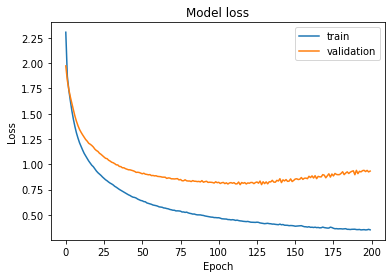

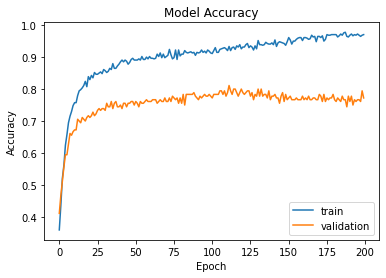

In [9]:
df_loss_acc = pd.DataFrame(history.history)
df_loss= df_loss_acc[['loss','val_loss']]
df_loss.rename(columns={'loss':'train','val_loss':'validation'},inplace=True)
df_acc= df_loss_acc[['accuracy','val_accuracy']]
df_acc.rename(columns={'accuracy':'train','val_accuracy':'validation'},inplace=True)
df_loss.plot(title='Model loss',figsize=(6,4)).set(xlabel='Epoch',ylabel='Loss')
df_acc.plot(title='Model Accuracy',figsize=(6,4)).set(xlabel='Epoch',ylabel='Accuracy')

Display the confusion matrix

6/6 [==============================] - 0s 16ms/step


[Text(0.5, 15.0, 'prediction'), Text(33.0, 0.5, 'actual')]

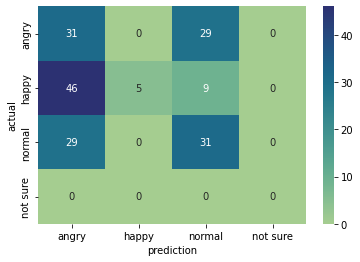

In [11]:
Y_pred = conv_model.predict(X_test)
Y_test_numpy = Y_test.numpy()
emotion_pred = []
emotion_test = []
for i in range(len(Y_pred)):
    if (Y_pred[i][0] > 0.5):
        emotion_pred.append(0) # angry
    elif (Y_pred[i][1] > 0.5):
        emotion_pred.append(1) # happy
    elif (Y_pred[i][2] > 0.5):
        emotion_pred.append(2) # normal
    else:
        emotion_pred.append(3) # not decided

    if (Y_test_numpy[i][0] > 0.5):
        emotion_test.append(0)
    elif (Y_test_numpy[i][1] > 0.5):
        emotion_test.append(1)
    elif (Y_test_numpy[i][2] > 0.5):
        emotion_test.append(2)

emotion_test = tf.convert_to_tensor(emotion_test)
emotion_pred = tf.convert_to_tensor(emotion_pred)

confusion = tf.math.confusion_matrix(emotion_test, emotion_pred, num_classes = 4)

df=pd.DataFrame(confusion.numpy(),index=['angry', 'happy', 'normal', 'not sure'],columns=['angry', 'happy', 'normal', 'not sure'])
confusiton_map = sn.heatmap(df,annot=True, cmap='crest')
confusiton_map.set(xlabel="prediction", ylabel="actual")